In [ ]:
from datetime import datetime, timedelta

# Parse option symbol and extract expiry, type, and strike price
def parse_option_symbol(symbol):
    # Example: SPX 240119P04700000
    numbers = symbol.split(' ')[3]
    expiry_date = numbers[:6]  # Expiry date in YYMMDD format
    option_type = numbers[6]  # P for put, C for call
    strike_price = float(numbers[7:]) / 1000  # Strike price divided by 1000
    return expiry_date, option_type, strike_price

def third_friday_of_month(date):
    # First day of the month
    first_day_of_month = date.replace(day=1)

    # Find the first Friday of the month
    first_friday_offset = (4 - first_day_of_month.weekday()) % 7  # 4 corresponds to Friday
    first_friday = first_day_of_month + timedelta(days=first_friday_offset)

    # The third Friday is 14 days after the first Friday
    third_friday = first_friday + timedelta(weeks=2)

    # If the current date is after the third Friday, move to the next month's third Friday
    if date > third_friday:
        # Move to the next month's first day
        next_month = (date.month % 12) + 1
        year = date.year + (1 if date.month == 12 else 0)
        first_day_of_next_month = datetime(year, next_month, 1)

        # Recalculate the third Friday for the next month
        first_friday_offset = (4 - first_day_of_next_month.weekday()) % 7
        first_friday = first_day_of_next_month + timedelta(days=first_friday_offset)
        third_friday = first_friday + timedelta(weeks=2)

    return third_friday


# Calculate time to expiration in years
def time_to_expiration(expiration_date_str, current_date):
    # Parse the expiration date string
    expiration_date = datetime.strptime(expiration_date_str, "%y%m%d")

    # Set the expiration time to 21:00 UTC on the third Friday (and make it timezone-naive)
    expiration_datetime = expiration_date.replace(hour=21, minute=0, second=0).replace(tzinfo=None)

    # Ensure current_date is also timezone-naive
    current_date = current_date.replace(tzinfo=None)

    # Calculate the time difference
    delta_seconds = (expiration_datetime - current_date).total_seconds()

    # Convert time difference to years
    delta_years = delta_seconds / (365.0 * 24 * 60 * 60)

    # Return the time to expiration in years, ensuring non-negative result
    return max(delta_years, 0)

In [ ]:
#get data
!mkdir data
!wget -P data https://github.com/Cornell-Quant-Fund/CTC-2024-Derivatives/raw/refs/heads/main/data/cleaned_options_data.zip
!unzip data/cleaned_options_data.zip -d data

mkdir: cannot create directory ‘data’: File exists
--2024-10-11 04:42:48--  https://github.com/Cornell-Quant-Fund/CTC-2024-Derivatives/raw/refs/heads/main/data/cleaned_options_data.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Cornell-Quant-Fund/CTC-2024-Derivatives/refs/heads/main/data/cleaned_options_data.zip [following]
--2024-10-11 04:42:48--  https://raw.githubusercontent.com/Cornell-Quant-Fund/CTC-2024-Derivatives/refs/heads/main/data/cleaned_options_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23864739 (23M) [application/zip]
Saving to: ‘data/cleaned_options_data.zip.5

In [ ]:
import pandas as pd
import numpy as np

#this function is adapted from shahzeb's version, in that it now serves any date and it use vectorized operation
def calculate_implied_spot_price(df, day, risk_free_rate=0.03):
    # Convert 'ts_recv' to a datetime object without timezone info
    df['timestamp'] = pd.to_datetime(df['ts_recv']).dt.tz_localize(None)

    # Filter the data for the specified day
    df = df[df['timestamp'].dt.date == day.date()]

    # **Time Filtering**: Keep data only within trading hours (14:30 to 21:00 UTC)
    start_time = pd.Timestamp(day.date()) + pd.Timedelta(hours=14, minutes=30)
    end_time = pd.Timestamp(day.date()) + pd.Timedelta(hours=21)

    df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]

    # Floor timestamp to the nearest second to group data per second
    df['timestamp_sec'] = df['timestamp'].dt.floor('s')

    # Parse option symbol into expiry date, option type, and strike price
    # Assuming parse_option_symbol returns expiry_date, option_type, strike_price
    df[['expiry_date', 'option_type', 'strike_price']] = df['symbol'].apply(
        lambda x: pd.Series(parse_option_symbol(x))
    )

    # Calculate midpoint price
    df['bid_ask_size_sum'] = df['bid_sz_00'] + df['ask_sz_00']
    df['midpoint_price'] = (df['bid_px_00'] * df['ask_sz_00'] + df['ask_px_00'] * df['bid_sz_00']) / df['bid_ask_size_sum']

    # Initialize VWAP trackers
    call_vwap_tracker = {}
    put_vwap_tracker = {}

    # Group data by timestamp_sec for efficient processing
    grouped = df.groupby('timestamp_sec')

    implied_spot_prices = []

    for timestamp_sec, group in grouped:
        # Process options data in the group
        for key, option_group in group.groupby(['strike_price', 'expiry_date', 'option_type']):
            strike_price, expiry_date, option_type = key

            # Sum sizes and weighted prices
            if option_type == 'C':
                total_volume = option_group['ask_sz_00']
            else:
                total_volume = option_group['bid_sz_00']
            weighted_price_sum = (option_group['midpoint_price'] * total_volume).sum()
            total_volume_sum = total_volume.sum()
            vwap = weighted_price_sum / total_volume_sum if total_volume_sum > 0 else option_group['midpoint_price'].iloc[-1]

            # Update VWAP trackers
            vwaps = call_vwap_tracker if option_type == 'C' else put_vwap_tracker
            key_simple = (strike_price, expiry_date)

            if key_simple not in vwaps:
                vwaps[key_simple] = {'total_volume': 0, 'weighted_price_sum': 0}

            vwaps[key_simple]['total_volume'] += total_volume_sum
            vwaps[key_simple]['weighted_price_sum'] += weighted_price_sum
            vwaps[key_simple]['vwap'] = vwaps[key_simple]['weighted_price_sum'] / vwaps[key_simple]['total_volume']

        # After updating VWAPs, check for keys present in both trackers
        common_keys = set(call_vwap_tracker.keys()).intersection(put_vwap_tracker.keys())

        for key in common_keys:
            strike_price, expiry_date = key
            call_vwap = call_vwap_tracker[key]['vwap']
            put_vwap = put_vwap_tracker[key]['vwap']

            # Calculate time to expiration T
            T = time_to_expiration(expiry_date, timestamp_sec)

            # Calculate implied spot price using Put-Call Parity
            implied_spot_price = call_vwap - put_vwap + strike_price * np.exp(-risk_free_rate * T)
            implied_spot_prices.append({
                'timestamp': timestamp_sec,
                'strike_price': strike_price,
                'implied_spot_price': implied_spot_price,
                'time_to_expiration': T,
                'expiry': expiry_date
            })

    # Return the results as a DataFrame
    return pd.DataFrame(implied_spot_prices)

## Data Exploration

In [ ]:
import pandas as pd
# Assuming the data is loaded into df already
df = pd.read_csv('data/cleaned_options_data.csv')

In [ ]:
# Use the function to calculate implied spot prices for January 2nd
implied_spot_prices_jan_2_df = calculate_implied_spot_price(df,datetime(2024, 1, 2), risk_free_rate=0.038)

# Display the results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Implied Spot Prices for January 2nd", dataframe=implied_spot_prices_jan_2_df)



In [ ]:
df.head(5)

,ts_recv,instrument_id,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,symbol,timestamp
0,2024-01-02T14:30:02.402838204Z,587228771,27.0,27.70,174,155,SPX 240119P04700000,2024-01-02 14:30:02.402838204
1,2024-01-02T14:30:02.402844171Z,587211744,1.6,1.75,755,1981,SPX 240119P04300000,2024-01-02 14:30:02.402844171
2,2024-01-02T14:30:02.402848382Z,587211728,4.1,4.40,1566,1125,SPX 240119P04500000,2024-01-02 14:30:02.402848382
3,2024-01-02T14:30:02.410507796Z,587246038,121.1,123.70,15,15,SPX 240216P04850000,2024-01-02 14:30:02.410507796
4,2024-01-02T14:30:02.410507796Z,587237433,42.7,43.40,75,120,SPX 240216P04650000,2024-01-02 14:30:02.410507796


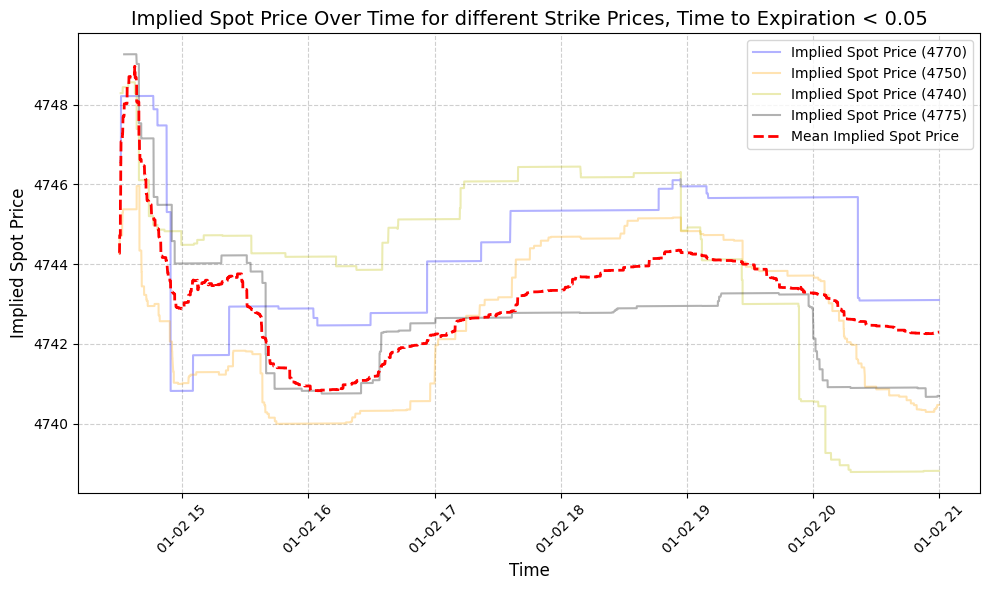

In [ ]:
import matplotlib.pyplot as plt

# Plot the implied spot price for different strike prices
time = 0.05

# Filter the DataFrame for time to expiration less than the given time
filtered_data_time = implied_spot_prices_jan_2_df[implied_spot_prices_jan_2_df['time_to_expiration'] < time]

# Define strike prices and colors
strike_prices = [4770, 4750, 4740, 4775]
colors = ['b', 'orange', 'y', 'black']

plt.figure(figsize=(10, 6))

# Plot individual strike price implied spot prices with lighter colors
for strike_price, color in zip(strike_prices, colors):
    filtered_data = filtered_data_time[filtered_data_time['strike_price'] == strike_price]

    plt.plot(filtered_data['timestamp'], filtered_data['implied_spot_price'],
             linestyle='-', color=color, alpha=0.3,  # Added alpha for transparency
             label=f'Implied Spot Price ({strike_price})')

# Calculate and plot the mean implied spot price across all strike prices
mean_data = filtered_data_time.groupby('timestamp')['implied_spot_price'].mean()

plt.plot(mean_data.index, mean_data.values, linestyle='--', color='red',
         label='Mean Implied Spot Price', linewidth=2)

# Set plot title and labels
plt.title(f'Implied Spot Price Over Time for different Strike Prices, Time to Expiration < {time}', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Implied Spot Price', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best')

# Display the plot
plt.tight_layout()
plt.show()

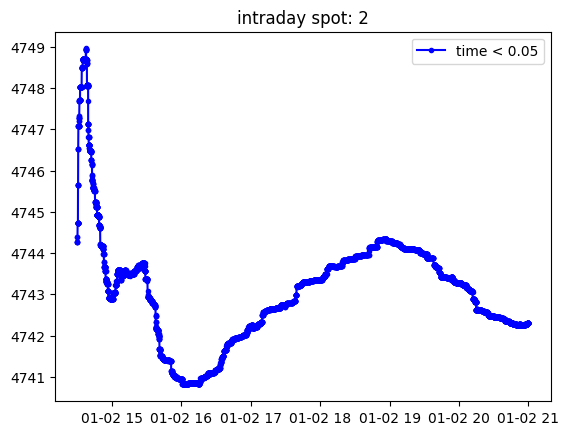

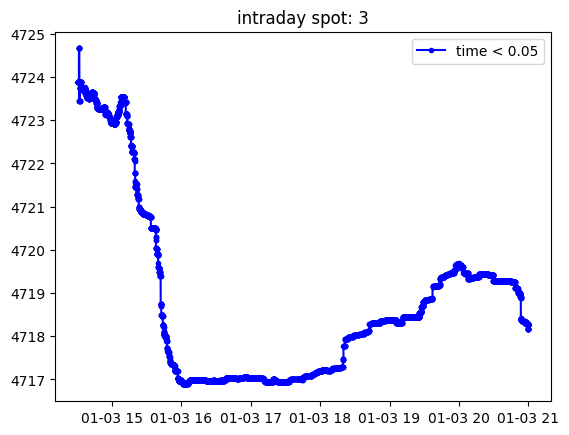

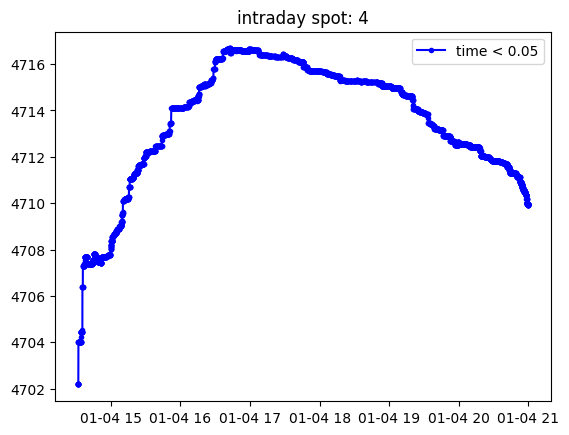

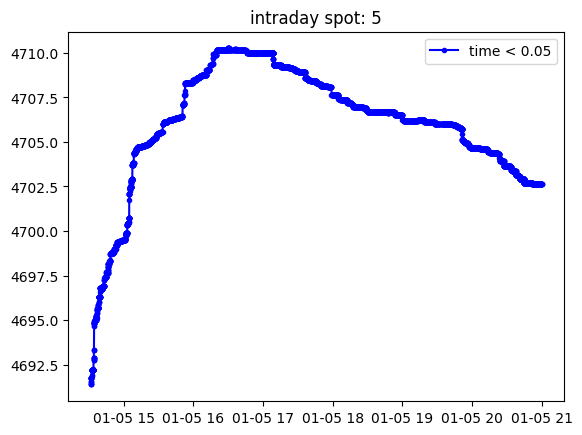

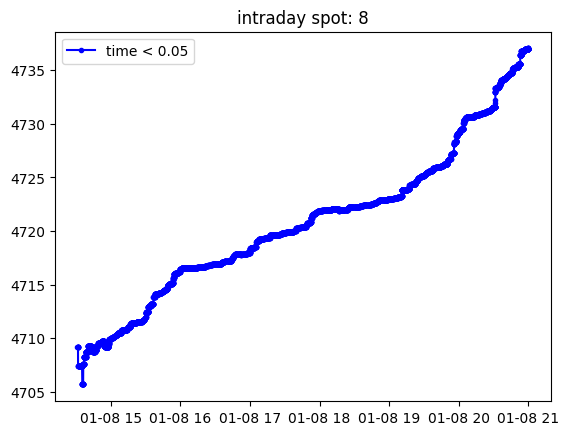

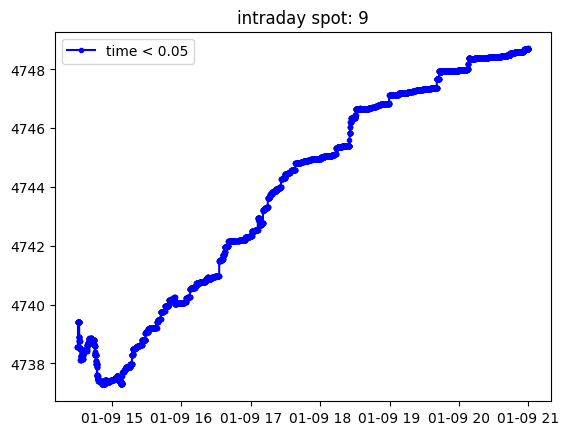

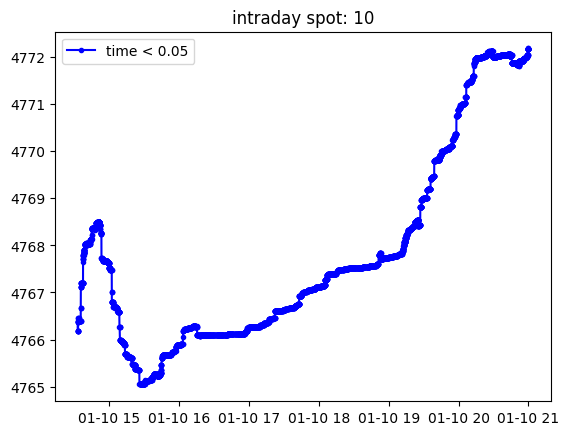

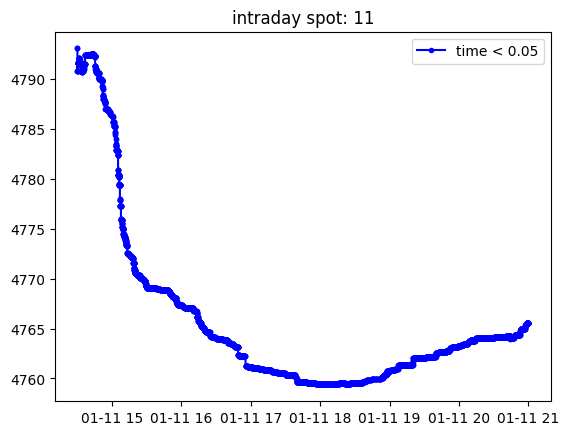

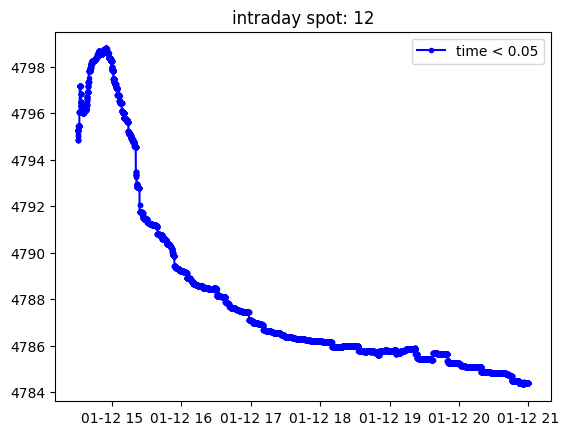

In [ ]:
test_ts = {}
test_spot = {}

#for now we use the first 13 days
for i in range(1,13):
  try:
    temp_df = calculate_implied_spot_price(df,datetime(2024, 1, i), risk_free_rate = 0.038)
  except Exception as e:
    #skip weekends where there is no data
    continue

  ts = []
  implied_spot_price_avg = []
  for timestamp, second in temp_df[(temp_df['time_to_expiration'] < 0.05)].groupby('timestamp'):
    ts.append(timestamp)
    implied_spot_price_avg.append(second['implied_spot_price'].mean())

  test_ts[i] = ts
  test_spot[i] = implied_spot_price_avg

  plt.title('intraday spot: %s'%i)
  plt.plot(ts,implied_spot_price_avg, marker = '.', color = 'b', label = 'time < 0.05')
  plt.legend()
  plt.show()

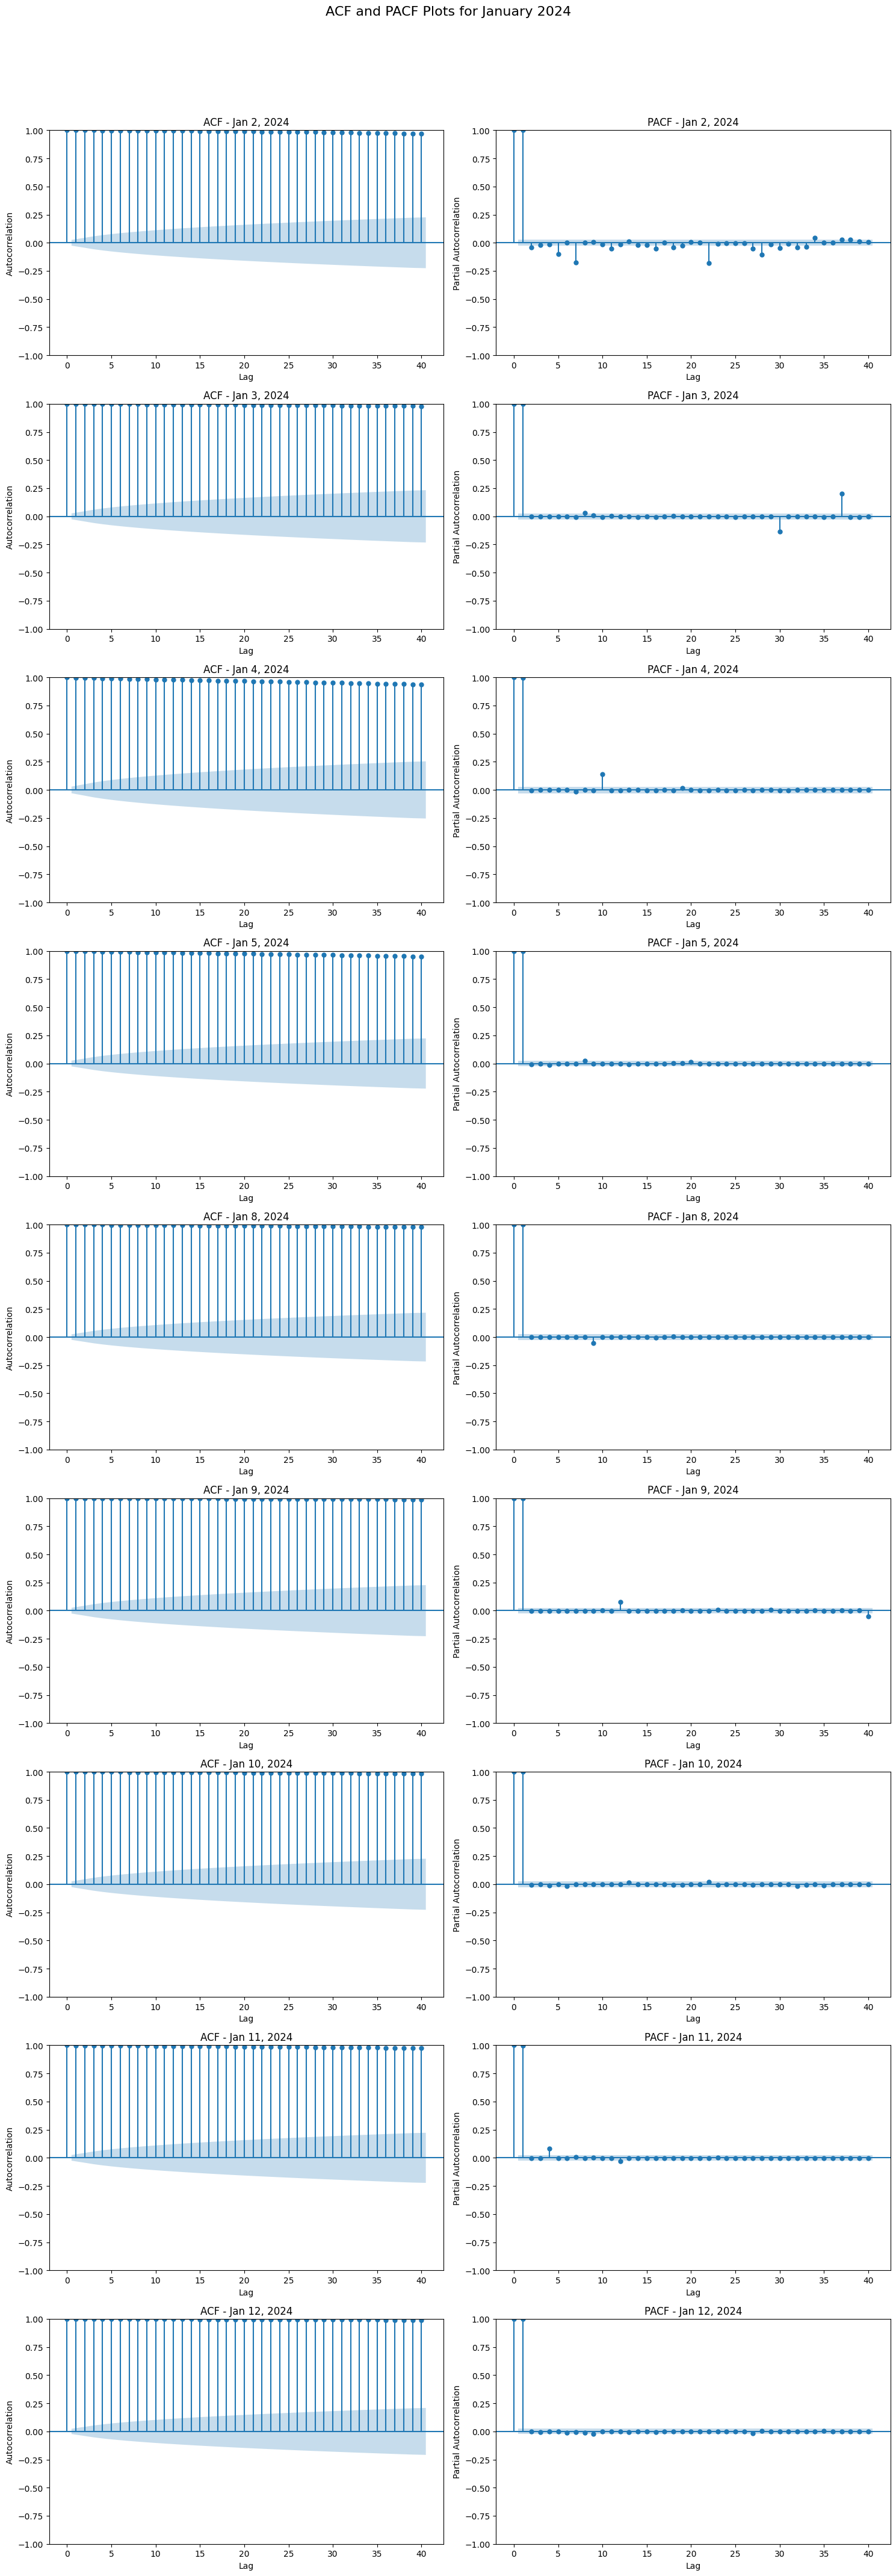

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

# Calculate the number of rows and columns for the subplots
num_days = len(test_ts.keys())
num_cols = 2  # We'll have ACF and PACF side by side
num_rows = num_days

# Create a large figure to accommodate all subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.suptitle('ACF and PACF Plots for January 2024', fontsize=16)

for idx, key in enumerate(test_ts.keys()):
    time_series = np.array(test_spot[key])

    # Plot ACF
    plot_acf(time_series, ax=axs[idx, 0], lags=40, title=f'ACF - Jan {key}, 2024')
    axs[idx, 0].set_xlabel('Lag')
    axs[idx, 0].set_ylabel('Autocorrelation')

    # Plot PACF
    plot_pacf(time_series, ax=axs[idx, 1], lags=40, title=f'PACF - Jan {key}, 2024')
    axs[idx, 1].set_xlabel('Lag')
    axs[idx, 1].set_ylabel('Partial Autocorrelation')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
#check simple OLS

#basically it tells me that under OLS assumption, the previous value is the best predictor for next value
#and that the residual is not IID normal
import statsmodels.api as sm

results = {}
def OLS_result(test_spot, key, lag = 1):

  X = test_spot[key][:-lag]
  y = test_spot[key][lag:]

  model = sm.OLS(y,X)

  return model.fit()


for key in test_ts.keys():
  results[key] = OLS_result(test_spot, key)

In [ ]:
#normalize residuals by time differences so that theoretically they have equal variance
resids_timeweighted = {}
for key in test_ts.keys():
  time_diff = np.diff(test_ts[key])
  time_diff_inseconds = np.vectorize(lambda x: x.total_seconds() / 60)(time_diff)
  price_diff = np.diff(test_spot[key])

  time_weighted_resid = price_diff / np.sqrt(time_diff_inseconds)

  resids_timeweighted[key] = time_weighted_resid

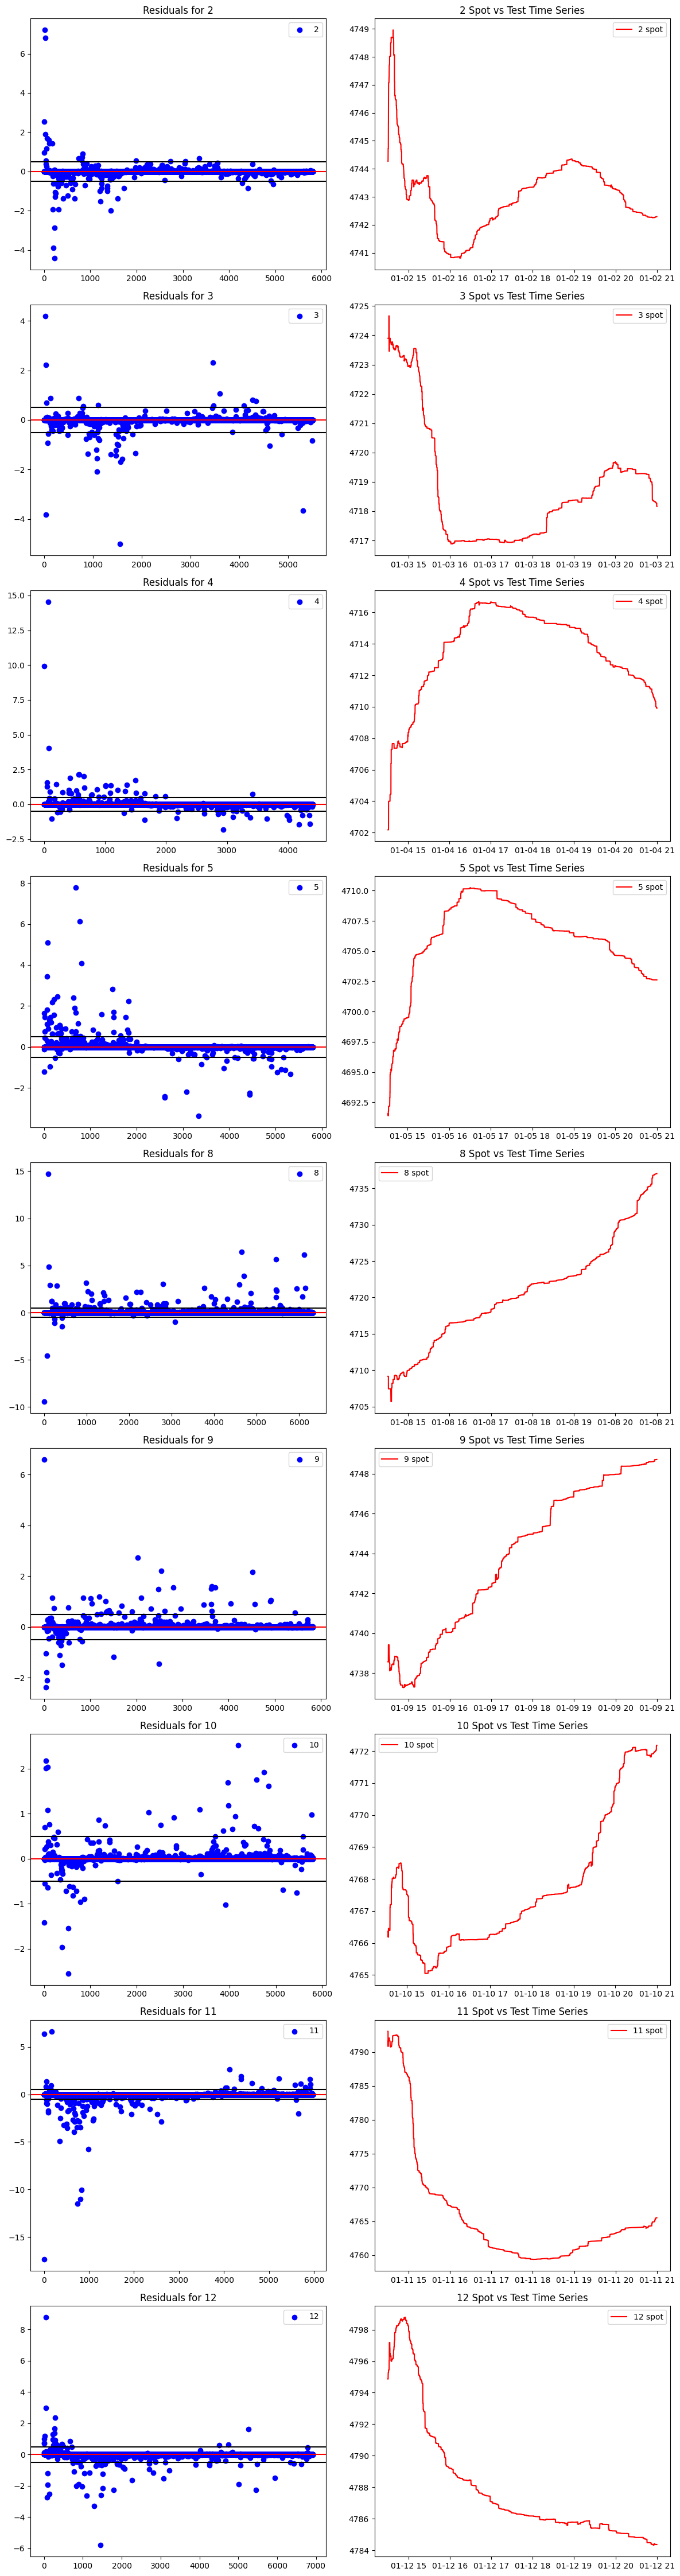

In [ ]:
import matplotlib.pyplot as plt

# Set up subplots for each key in test_ts
fig, axes = plt.subplots(len(test_ts), 2, figsize=(12, len(test_ts)*5))

# Iterate over each key
for idx, key in enumerate(test_ts.keys()):
    # Scatter plot of residuals
    axes[idx, 0].scatter(range(len(resids_timeweighted[key])), resids_timeweighted[key], color='b', label=f"{key}")
    level = 0.5
    axes[idx, 0].axhline(0, color='r')
    axes[idx, 0].axhline(level, color='black')
    axes[idx, 0].axhline(-level, color='black')
    axes[idx, 0].legend()
    axes[idx, 0].set_title(f'Residuals for {key}')

    # Line plot of test_ts vs. test_spot
    axes[idx, 1].plot(test_ts[key], test_spot[key], color='r', label=f'{key} spot')
    axes[idx, 1].legend()
    axes[idx, 1].set_title(f'{key} Spot vs Test Time Series')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

**first conclusion: definitely autoregressive.**

**residual is not normal, suggest a different structure than white noise.**




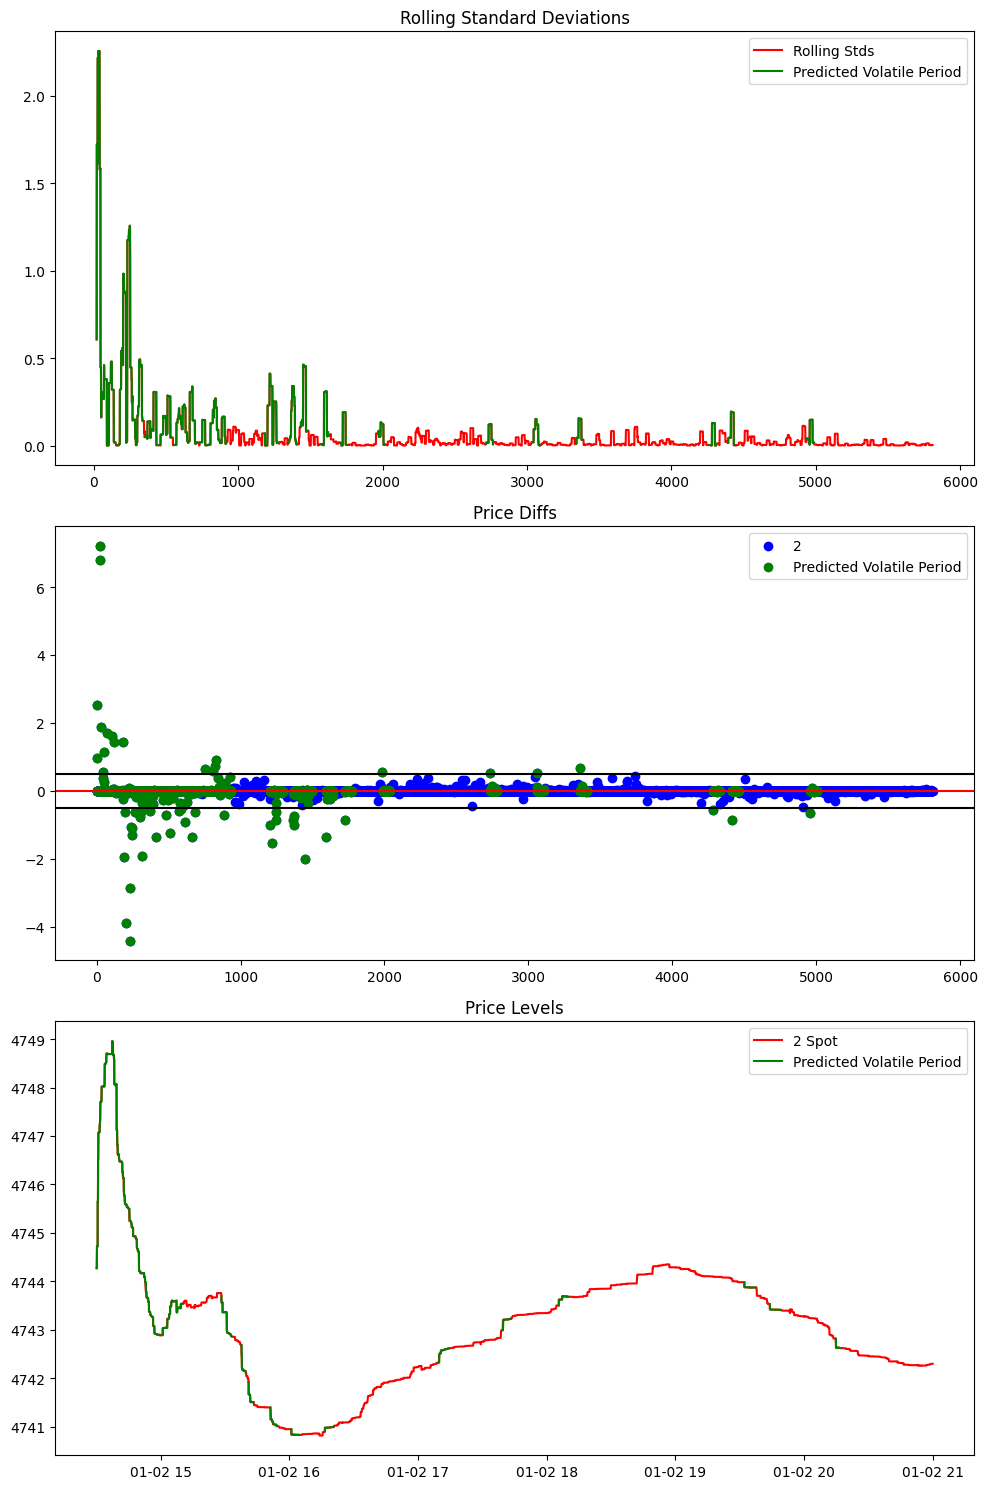

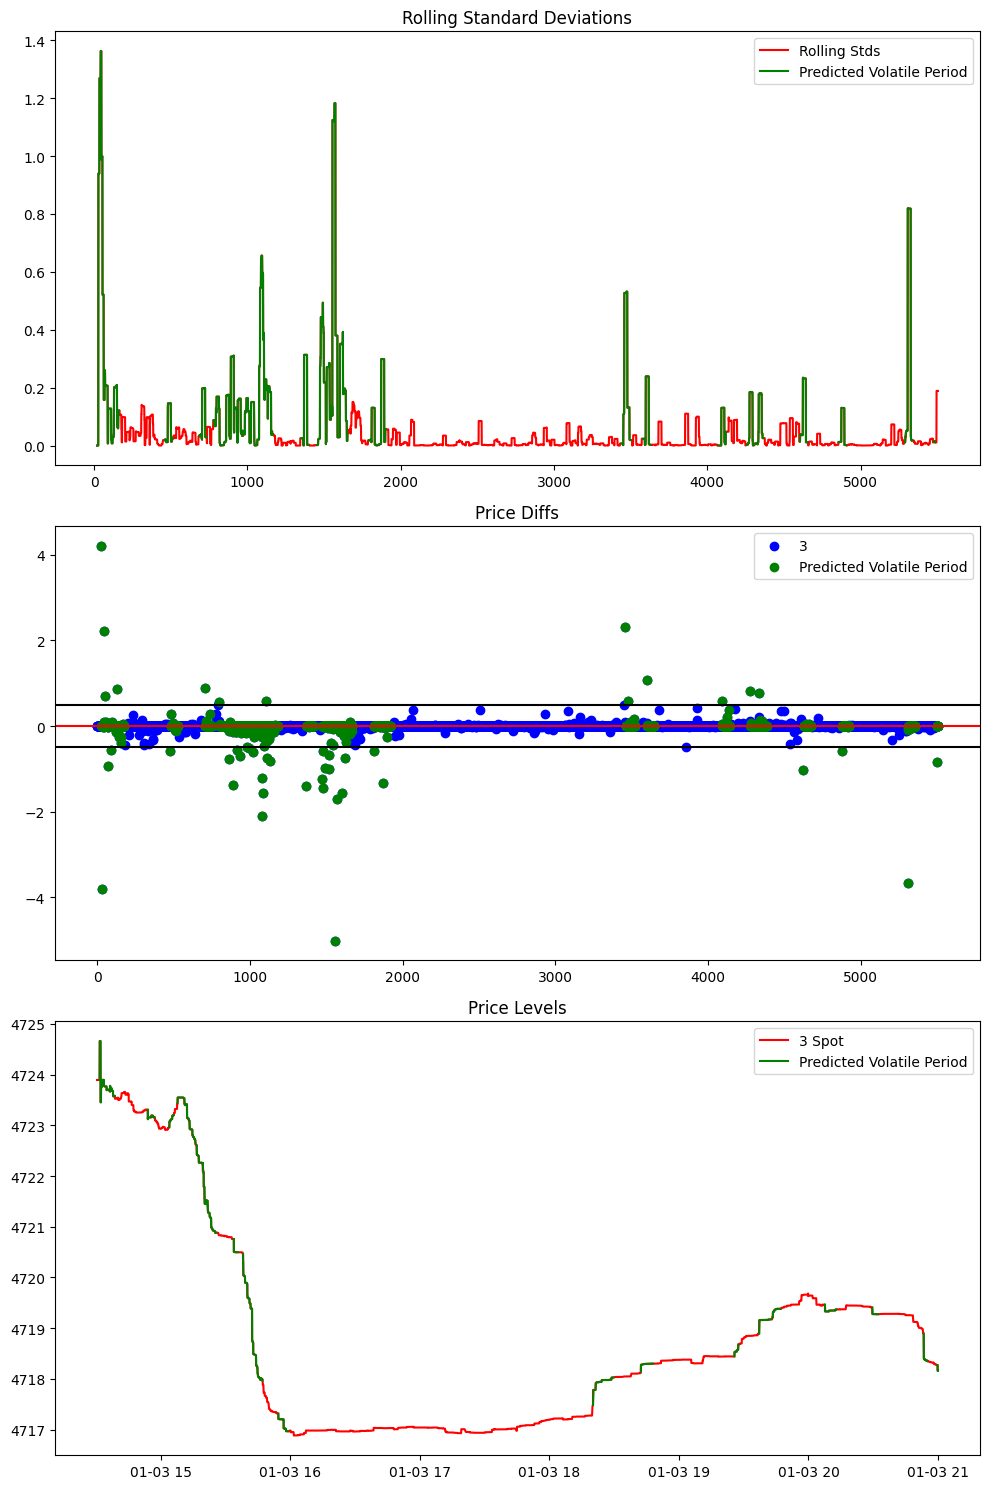

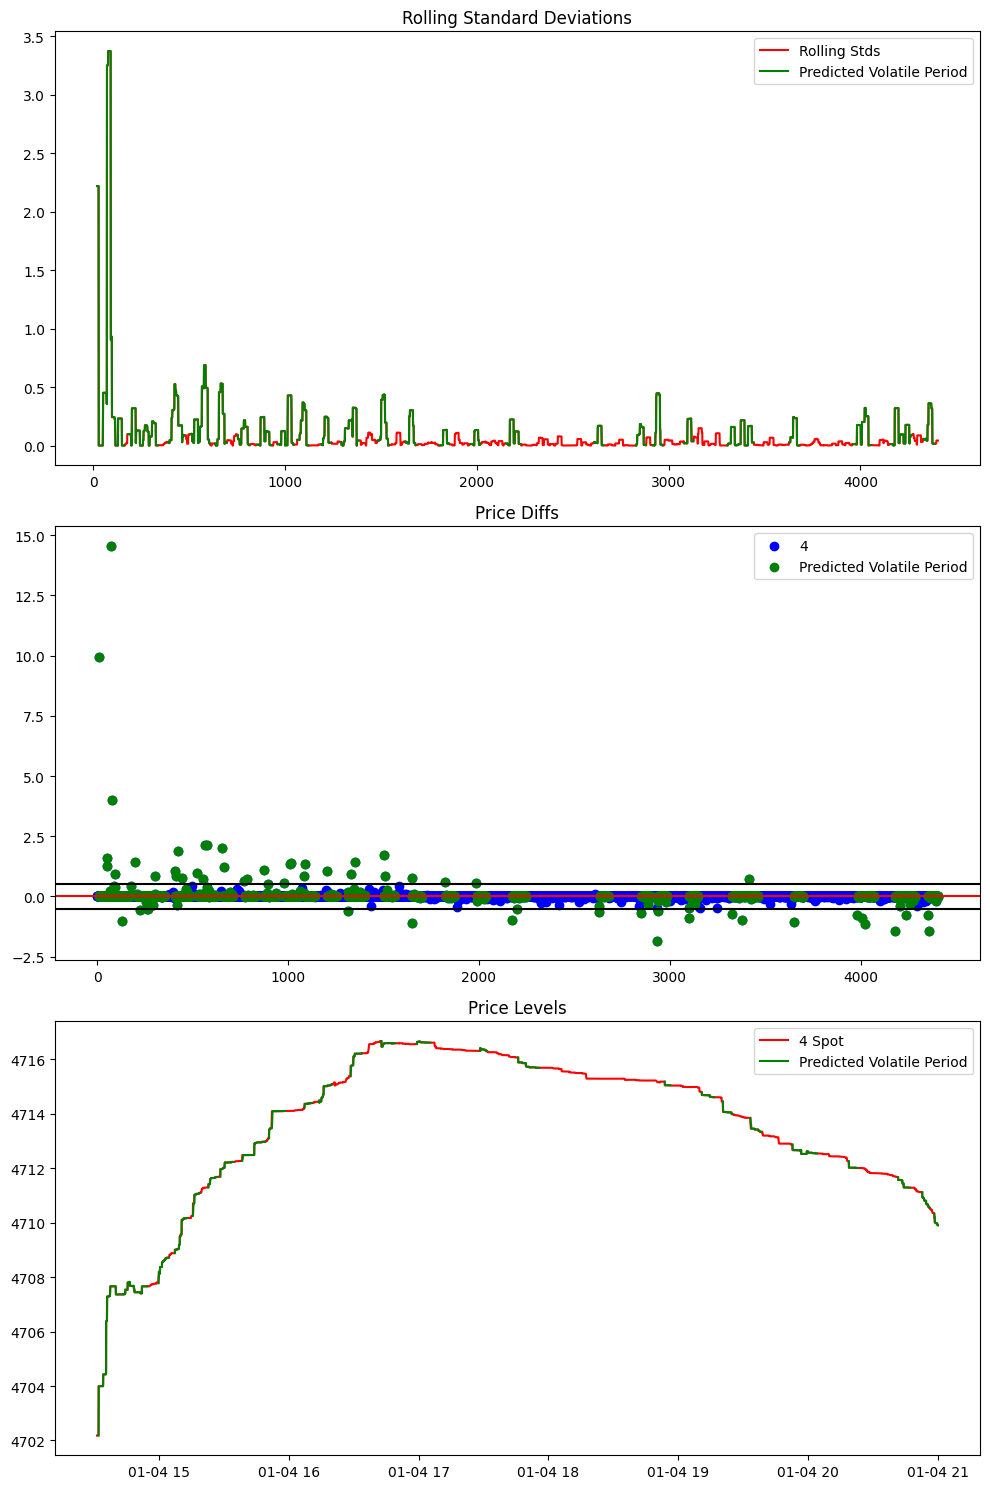

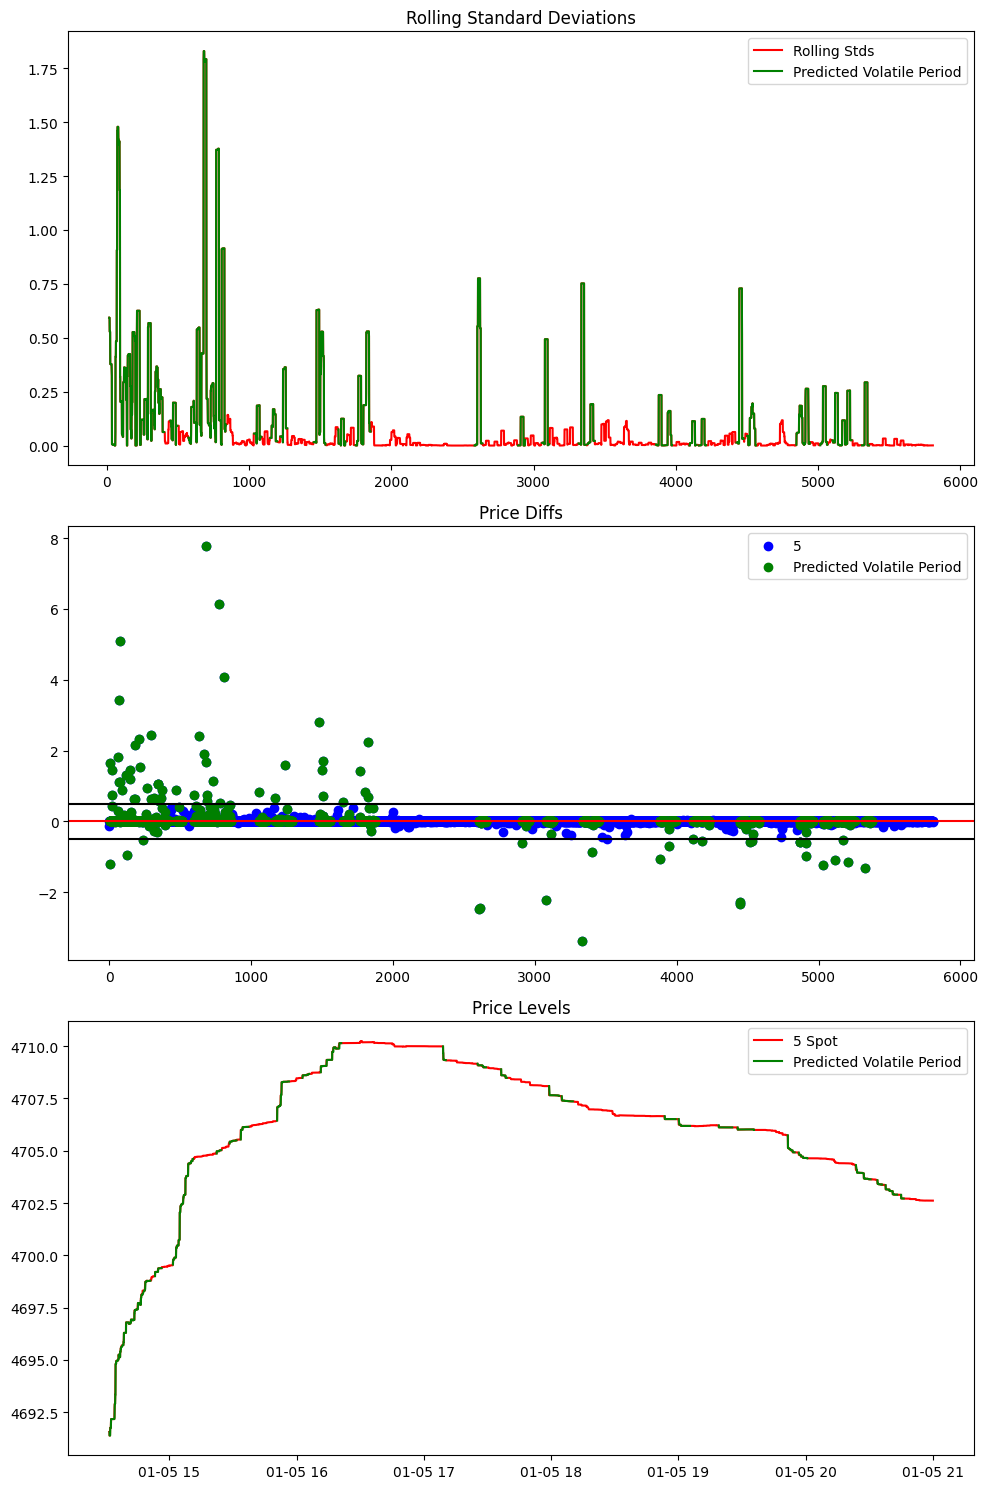

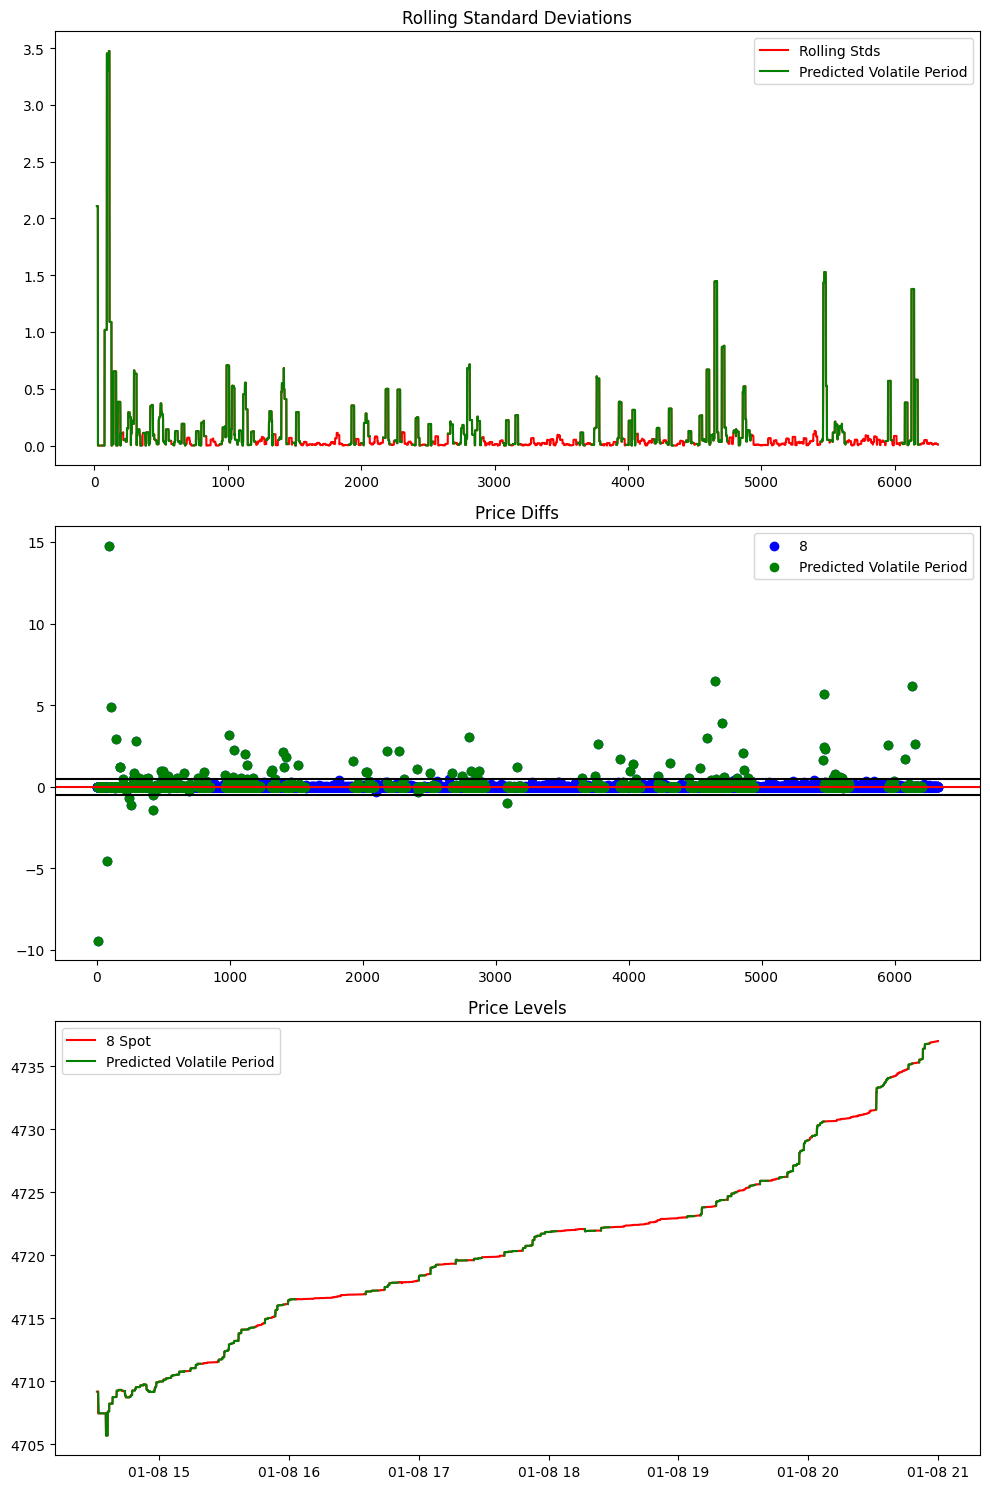

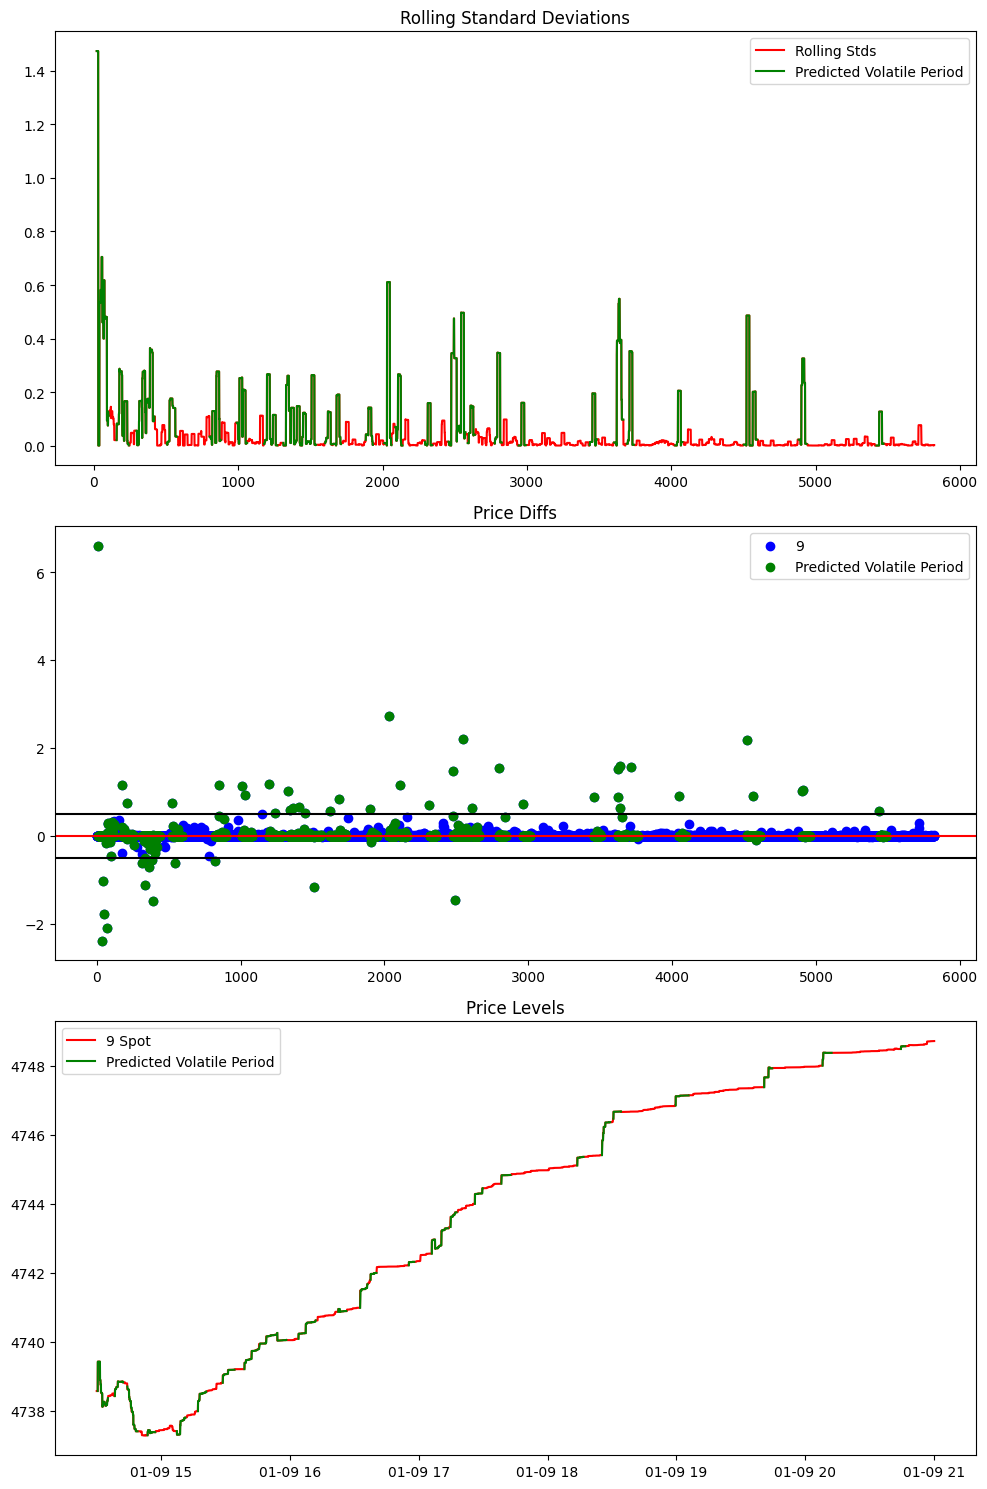

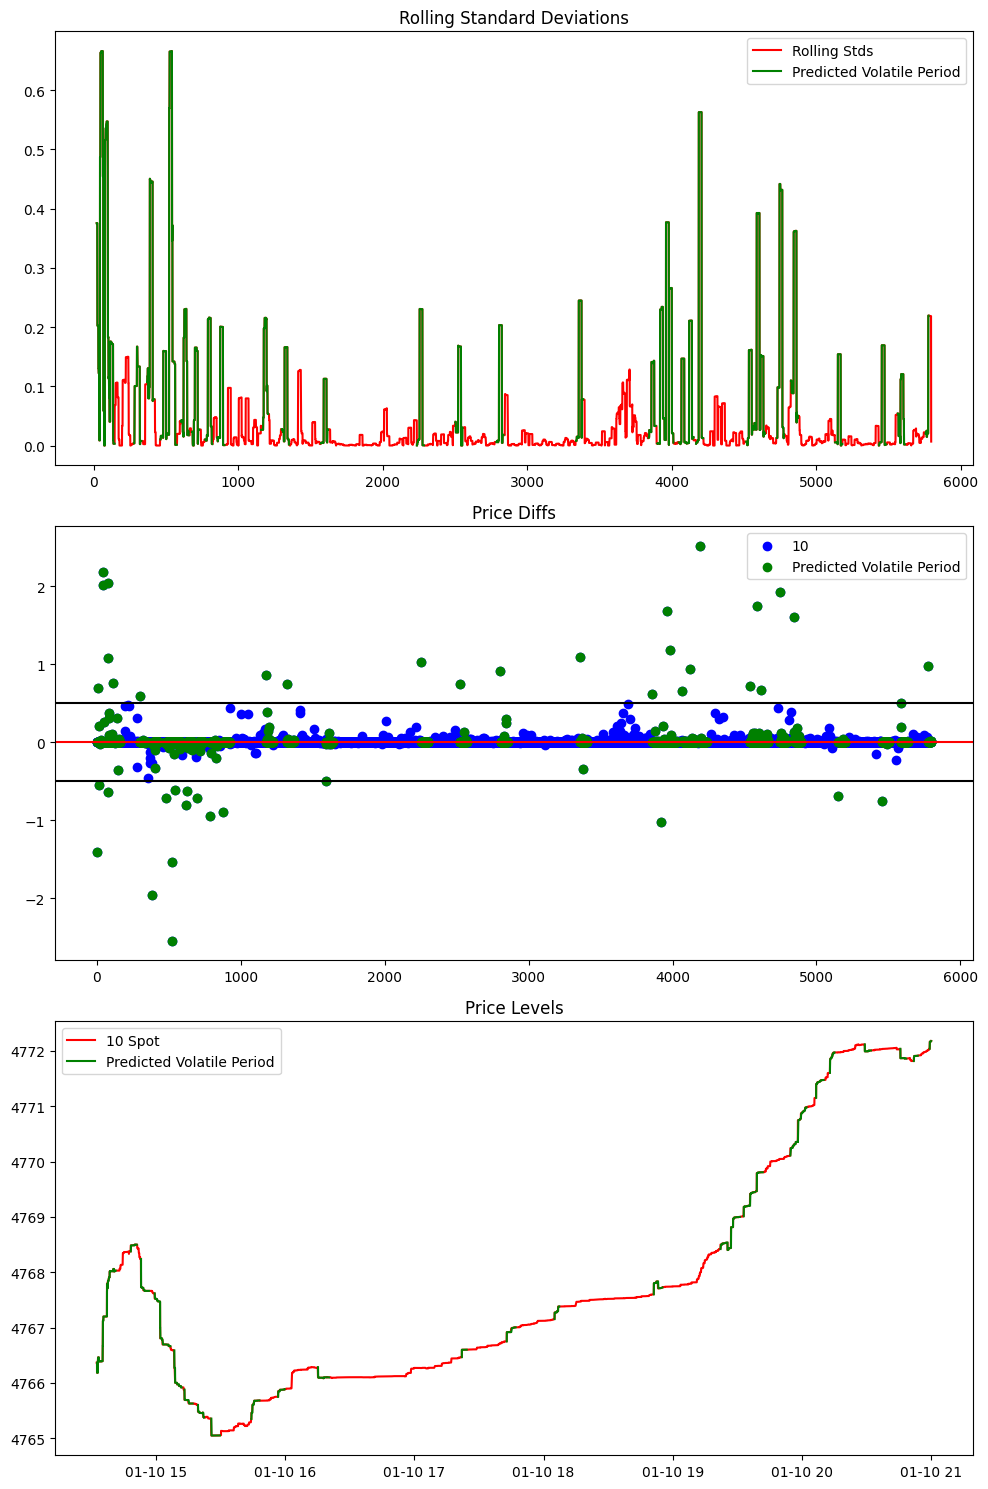

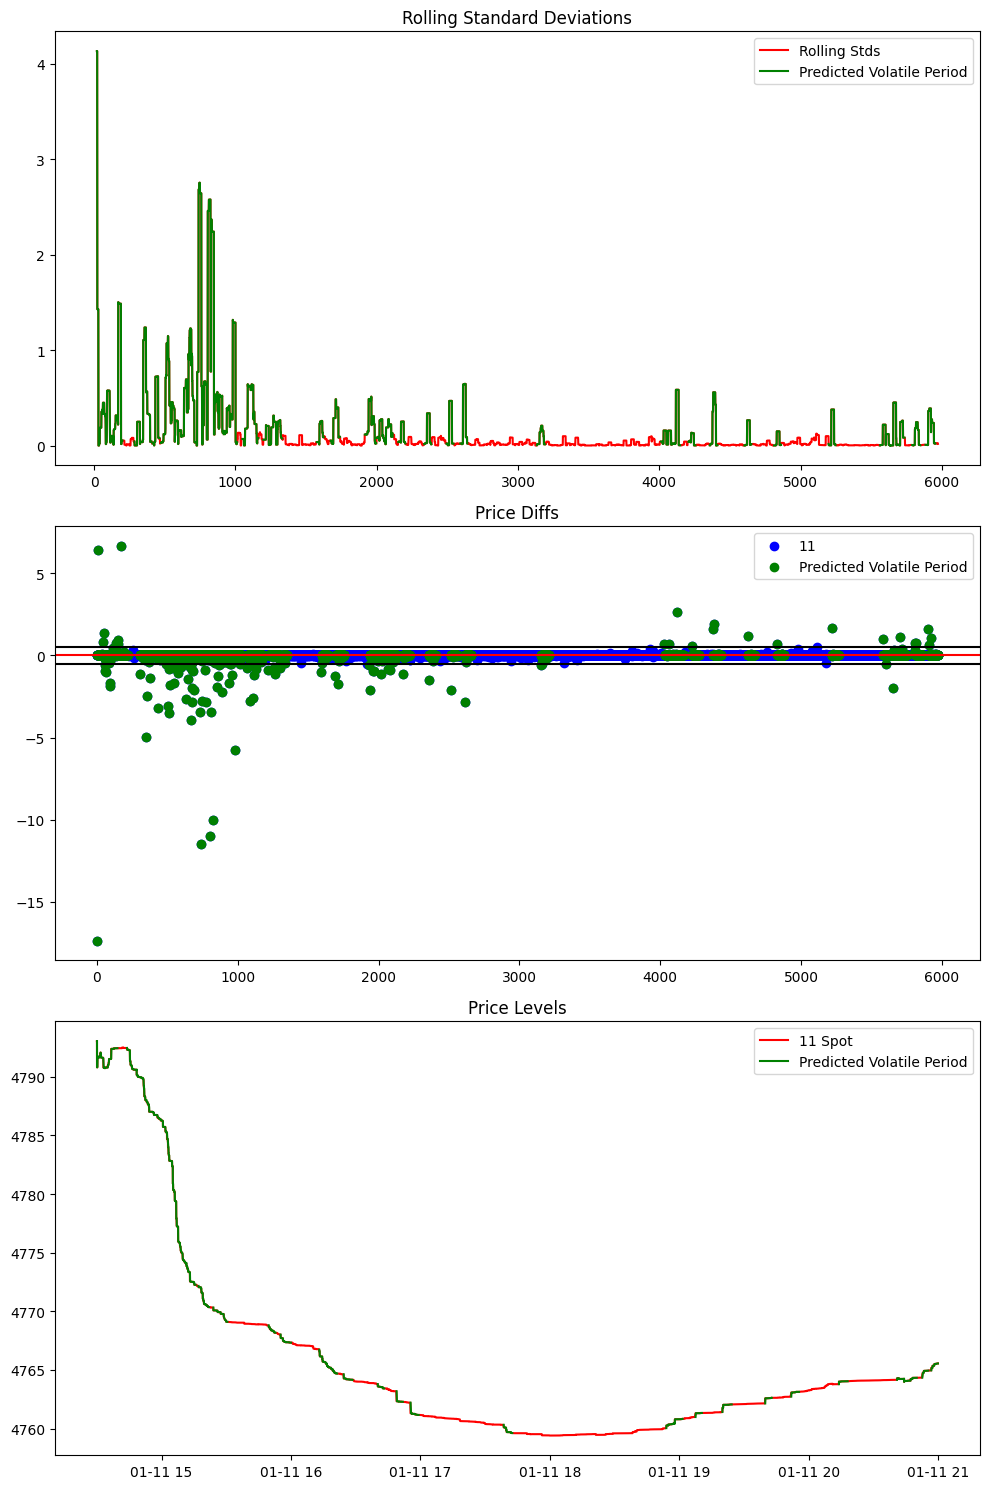

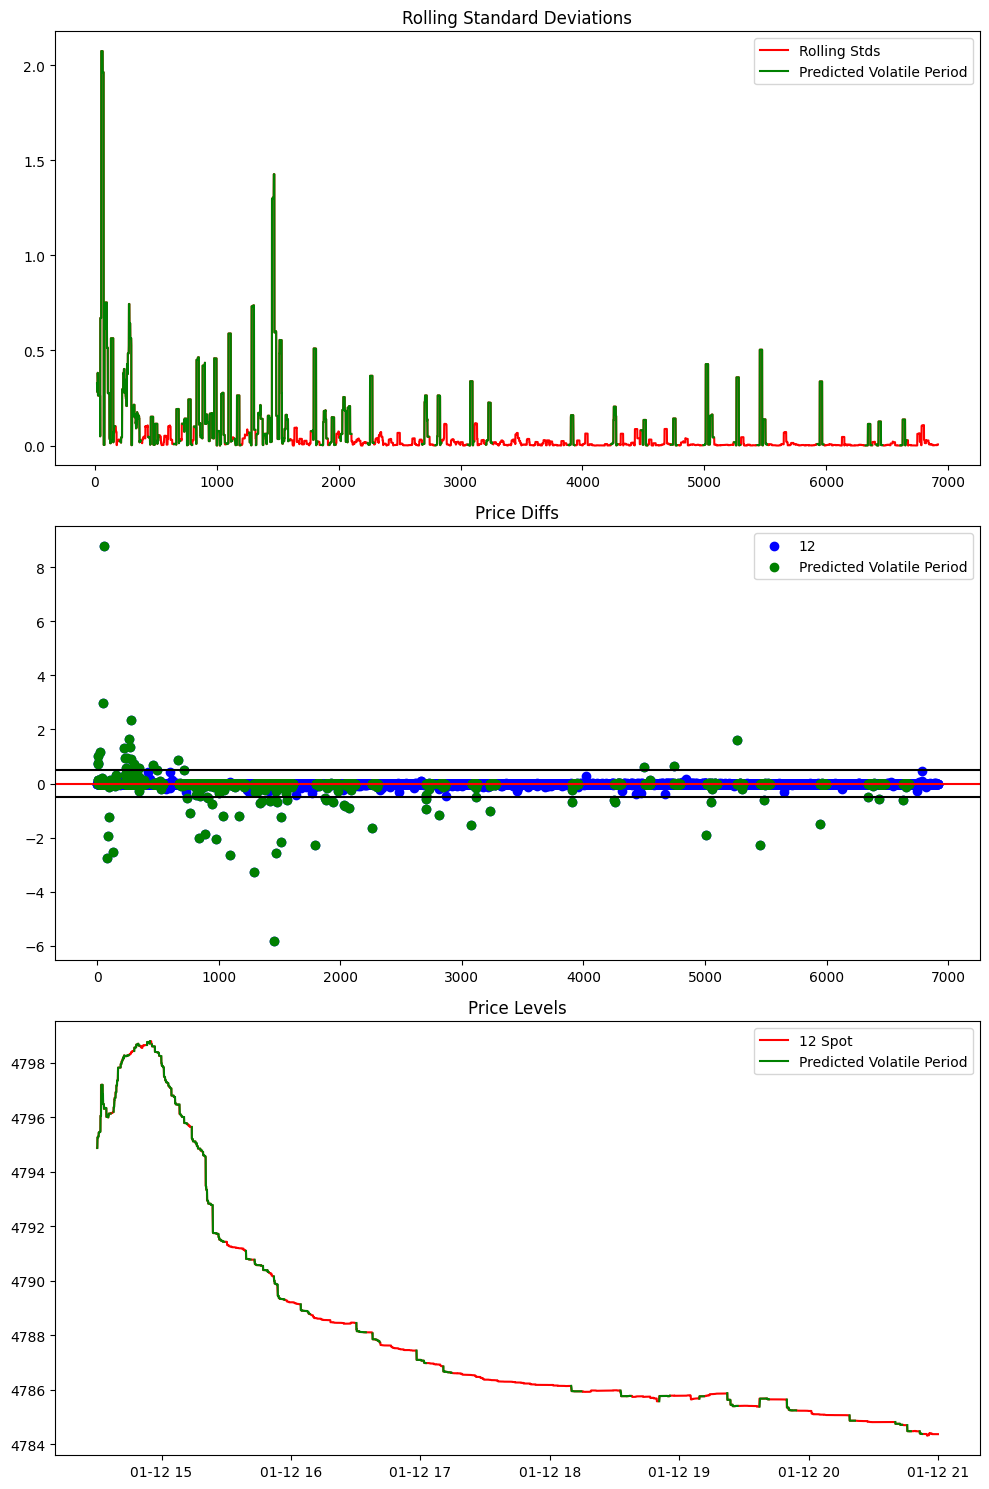

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up parameters for labeling
persist = 50
lag = 20
level = 0.5

# Loop through each key in test_ts
for key in test_ts.keys():
    # Prepare data for rolling standard deviation and residuals
    spot_times = []
    resid_times = []
    rolling_stds_times = []

    time_series = pd.Series(resids_timeweighted[key])
    rolling_stds = time_series.rolling(window=lag).apply(lambda x: ((x**2).mean())**0.5)

    trend = -1

    # Iterate through residuals to determine volatile periods
    for i in range(len(resids_timeweighted[key])):
        if abs(resids_timeweighted[key][i]) > 0.5:
            trend = 0
        elif trend >= 0:
            trend += 1

        if trend >= persist:
            trend = -1

        if trend >= 0:
            spot_times.append(test_spot[key][i])
            resid_times.append(resids_timeweighted[key][i])
            if i >= lag - 1:
                rolling_stds_times.append(rolling_stds[i - 19])
        else:
            spot_times.append(np.nan)
            resid_times.append(np.nan)
            if i >= lag - 1:
                rolling_stds_times.append(np.nan)

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Rolling standard deviation plot
    axs[0].plot(rolling_stds, color='r', label='Rolling Stds')
    axs[0].plot(rolling_stds_times, color='green', label='Predicted Volatile Period')
    axs[0].set_title('Rolling Standard Deviations')
    axs[0].legend()

    # Residuals plot
    axs[1].scatter(range(len(resids_timeweighted[key])), resids_timeweighted[key], color='b', label="%s" % key)
    axs[1].scatter(range(len(resids_timeweighted[key])), resid_times, color='green', label="Predicted Volatile Period")
    axs[1].axhline(0, color='r')
    axs[1].axhline(level, color='black')
    axs[1].axhline(-level, color='black')
    axs[1].set_title('Price Diffs')
    axs[1].legend()

    # Price levels plot
    axs[2].plot(test_ts[key], test_spot[key], color='r', label='%s Spot' % key)
    axs[2].plot(test_ts[key][1:], spot_times, color='green', label='Predicted Volatile Period')
    axs[2].set_title('Price Levels')
    axs[2].legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()
